In [1]:
# For Colab
import sys
if 'google.colab' in sys.modules:
    !pip -q install geopandas ortools
    !curl -O https://raw.githubusercontent.com/pjrule/covid-path-planning/master/miller_223.geojson
else:
    !pip -q install geopandas cvxpy matplotlib scipy ortools

In [2]:
%config InlineBackend.figure_formats = ['svg']
import cvxpy as cp
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from shapely.affinity import scale
from shapely.geometry.point import Point
from scipy.spatial import distance_matrix
from matplotlib.animation import FuncAnimation
from ortools.constraint_solver import routing_enums_pb2, pywrapcp

In [3]:
class Room:
    """Represents the geometries of a room and its guarded region."""
    def __init__(self, filename, room_res=1000, guard_res=1000, guard_scale=1):
        self.gdf = gpd.read_file(filename)
        self.guard_scale = guard_scale
        self.room = self.gdf[self.gdf['type'] == 'room'].iloc[0].geometry
        self.guard = box(*(scale(self.room, guard_scale, guard_scale).bounds))
        for obs in self.gdf[self.gdf['type'] == 'obstacle'].geometry:
            self.guard = self.guard.difference(obs)
        self.guard = self.guard.intersection(self.room)
        self.room_grid = self._grid(self.room, room_res)
        self.guard_grid = self._grid(self.guard, guard_res)
        
    @property
    def guard_geodesic_center(self):
        """Finds the best guard grid approximation of theroom grid's geodesic center."""
        # The geodesic center minimizes the maximum distance to any point.
        dist = distance_matrix(self.guard_grid, self.room_grid)
        return np.argmin(np.max(dist, axis=1))
        
    def _grid(self, geom, res):
        """Returns points within a geometry (gridded over its bounding box).
        
        Points on the grid inside the bounding box but outside the geometry
        are rejected.
        
        :param res: The number of points in the bounding box's grid (approx.)
        """
        minx, miny, maxx, maxy = geom.bounds
        aspect = (maxy - miny) / (maxx - minx)
        n_x_points = int(np.ceil(np.sqrt(res / aspect)))
        n_y_points = int(np.ceil(np.sqrt(res)))
        xx, yy = np.meshgrid(np.linspace(minx, maxx, n_x_points),
                             np.linspace(miny, maxy, n_y_points))
        filtered_points = []
        for x, y in zip(xx.flatten(), yy.flatten()):
            if geom.contains(Point((x, y))):
                filtered_points.append((x, y))
        return np.array(filtered_points)

In [4]:
class Path:
    """A path in a room."""
    def __init__(self, room, robot_height):
        if robot_height <= 0:
            raise PathError('Robot must have a positive height '
                            'to avoid degeneracies.')
        self.room = room
        self.robot_height = robot_height
        self.points = []
        self.room_intensities = None
        self.guard_intensities = None
        
    def __len__(self):
        return len(self.points)
        
    def append(self, index):
        """Adds a point in the guard grid to the path."""
        if index < 0 or index >= self.room.guard_grid.shape[0]:
            raise PathError(f'Point {index} out of bounds!')
        if index in self.points:
            raise PathError(f'Point {index} already in path!')
        self.points.append(index)
        x, y = self.room.guard_grid[index]
        
        room_point_intensities = 1 / ((x - self.room.room_grid[:, 0])**2 + 
                                      (y - self.room.room_grid[:, 1])**2 +
                                      self.robot_height)
        room_point_intensities = room_point_intensities.reshape(1, -1)
        if self.room_intensities is None:
            self.room_intensities = room_point_intensities
        else:
            self.room_intensities = np.append(self.room_intensities,
                                              room_point_intensities,
                                              axis=0)
            
        guard_point_intensities = 1 / ((x - self.room.guard_grid[:, 0])**2 +
                                       (y - self.room.guard_grid[:, 1])**2 +
                                       self.robot_height)
        guard_point_intensities = guard_point_intensities.reshape(1, -1)
        if self.guard_intensities is None:
            self.guard_intensities = guard_point_intensities
        else:
            self.guard_intensities = np.append(self.guard_intensities,
                                               guard_point_intensities,
                                               axis=0)
            
    def filter_path(self, point_indices=None):
        """Returns a `Path` constructed from an iterable of point indices.
        
        For instance, `path.filter_path([0, 1, 2])` constructs a new `Path`
        consisting of the first three points in `path`.
        """
        if point_indices is None:
            point_indices = range(len(self.points))
        filtered_points = []
        for new_idx, old_idx in enumerate(point_indices):
            if old_idx < 0 or old_idx >= self.room.guard_grid.shape[0]:
                raise PathError(f'Point {old_idx} out of bounds!')
            filtered_path.append(self.points[old_idx])
        p = Path(self.room, self.robot_height)
        p.points = filtered_points
        p.room_intensities = self.room_intensities[point_indices]
        p.guard_intensities = self.guard_intensities[point_indices]
        return p
            
    def room_illumination(self):
        """Calculates illumination per unit time on the room grid."""
        if self.room_intensities is None:
            return None
        return self.room_intensities.sum(axis=0)
    
    def guard_illumination(self):
        """Calculates illumination per unit time on the guard grid."""
        if self.guard_intensities is None:
            return None
        return self.guard_intensities.sum(axis=0)
            
    def times(self, min_intensity):
        """Computes minimum time until all points in the room are saturated.
                
        :return: The time spent at each location in the path.
        """
        # Compute times to ensure minimum illumination.
        loc_times = cp.Variable(len(self.points))
        obj = cp.Minimize(cp.sum(loc_times))
        constraints = [
            self.room_intensities.T @ loc_times >= min_intensity,
            loc_times >= 0
        ]
        prob = cp.Problem(obj, constraints=constraints)
        prob.solve()
        assert prob.status == 'optimal'
        return np.array(loc_times.value)    
    
    def route(self, scale_factor=10000):
        """Computes an approximate TSP route for the path.

        Heavily based on examples from:
        https://developers.google.com/optimization/routing/tsp#tsp_py

        :return: A dictionary containing the total length of the path
          and the order of points on the path (represented as path
          indices).
        """
        scaled_locs = np.round(scale_factor *
                               self.room.guard_grid[self.points])
        manager = pywrapcp.RoutingIndexManager(len(self.points), 1, 0)
        routing = pywrapcp.RoutingModel(manager)
        dists = distance_matrix(scaled_locs, scaled_locs)

        def distance_callback(from_index, to_index):
            """Returns the distance between the two nodes."""
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return dists[from_node][to_node]

        callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(callback_index)

        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)
        total_distance = 0
        index = routing.Start(0)
        path_indices = []
        while not routing.IsEnd(index):
            path_indices.append(manager.IndexToNode(index))
            prev = index
            index = solution.Value(routing.NextVar(index))
            total_distance += routing.GetArcCostForVehicle(prev, index, 0)
        path_indices.append(manager.IndexToNode(index))

        return {
            'distance': total_distance / scale_factor,
            'path': path_indices
        }
    
    def distance(self):
        """Computes the approximate TSP distance for a path."""
        return self.route()['distance']

class PathError(Exception):
    """Raised for errors in path creation."""

In [5]:
room_file = 'miller_223.geojson'
room_sq_ft = 174
guard_scale = 0.75
robot_height_ft = 4
max_points = 20
min_intensity = 0.1

In [6]:
room = Room(room_file, guard_scale=guard_scale)
room_scale = np.sqrt(room_sq_ft / room.room.area)
robot_height_scaled = robot_height_ft / room_scale

In [7]:
# Starting at the guard geodesic center, greedily add
# the most dimly illuminated room point to the path.
greedy_path = Path(room, robot_height_scaled) 
greedy_path.append(room.guard_geodesic_center)
greedy_tsp_paths = [greedy_path.route(min_intensity)['path']]
greedy_times = [greedy_path.times(min_intensity)]
greedy_t_totals = [greedy_path.times(min_intensity).sum()]
greedy_dist_totals = [greedy_path.distance()]
while len(greedy_path) < max_points:
    for idx in np.argsort(greedy_path.guard_illumination()):
        if idx not in greedy_path.points:
            greedy_path.append(idx)
            break
    times = greedy_path.times(min_intensity)
    greedy_times.append(times)
    greedy_t_totals.append(times.sum())
    route = greedy_path.route()
    greedy_dist_totals.append(route['distance'])
    greedy_tsp_paths.append(route['path'])

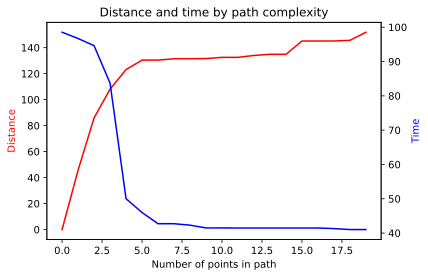

In [8]:
def distance_vs_time(dist_totals, t_totals):
    fig, dist_ax = plt.subplots()
    dist_ax.plot(dist_totals, color='red')
    dist_ax.set_title('Distance and time by path complexity')
    dist_ax.set_xlabel('Number of points in path')
    dist_ax.set_ylabel('Distance', color='red')
    time_ax = dist_ax.twinx()
    time_ax.plot(t_totals, color='blue')
    time_ax.set_ylabel('Time', color='blue')
distance_vs_time(greedy_dist_totals, greedy_t_totals)

## Full LP

In [9]:
room_intensities = 1 / ((np.tile(room.guard_grid[:, 0], (room.room_grid.shape[0], 1)).T -
                         np.tile(room.room_grid[:, 0], (room.guard_grid.shape[0], 1)))**2 + 
                        (np.tile(room.guard_grid[:, 1], (room.room_grid.shape[0], 1)).T -
                         np.tile(room.room_grid[:, 1], (room.guard_grid.shape[0], 1)))**2 +
                        robot_height_scaled)

In [10]:
loc_times = cp.Variable(room.guard_grid.shape[0])
obj = cp.Minimize(cp.sum(loc_times))
constraints = [
    room_intensities.T @ loc_times >= min_intensity,
    loc_times >= 0
]
prob = cp.Problem(obj, constraints=constraints)
prob.solve(solver='ECOS')

40.940110517717386

In [21]:
np.sort(loc_times.value)[-16:]

array([1.92386832e-10, 6.66803592e-10, 7.84298011e-10, 2.00325122e-03,
       2.77402561e-03, 5.33604266e-03, 6.40113865e-02, 6.41010578e-01,
       7.41649860e-01, 1.06767988e+00, 1.36312744e+00, 3.68323210e+00,
       3.86793264e+00, 6.24540651e+00, 1.02976386e+01, 1.29583082e+01])

## Evolutionary algorithm
(Terrible baseline)

In [11]:
pop_size = 60
n_keep_elite = 10
n_random = 10
candidate_points = 10
n_generations = 30
alpha = 1
n_parents = 2

In [12]:
def eval_population(pop):
    """Evaluates a population by time."""
    times = []
    time_sums = []
    for candidate in pop:
        path = Path(room, robot_height_scaled)
        for point in candidate:
            path.append(point)
        t = path.times(min_intensity)
        times.append(t)
        time_sums.append(t.sum())
    return time_sums, times

def next_gen(pop, scores, subscores):
    """Generates a new population."""
    pop = np.array(pop)
    scores = np.array(scores)
    subscores = np.array(subscores)
    elite = np.argsort(scores)[:n_keep_elite]
    new_pop = [pop[idx] for idx in elite]
    normalized_scores = (scores - scores.min()) / (scores.max() - scores.min())
    weights = np.exp(-normalized_scores * alpha)
    weights /= weights.sum()
    for _ in range(pop_size - n_keep_elite - n_random):
        # Use the `candidate_points` most important points.
        parents = np.random.choice(pop_size, n_parents)
        unique_indices = np.unique(pop[parents].flatten(), return_index=True)[1]
        parent_points = pop[parents].flatten()[unique_indices]
        parent_subscores = subscores[parents].flatten()[unique_indices]
        subscore_rank = np.argsort(parent_subscores)
        new_candidate = parent_points[subscore_rank[-candidate_points:]]
        new_pop.append(new_candidate)
    new_pop += [np.random.choice(room.guard_grid.shape[0], candidate_points, replace=False)
                for _ in range(n_random)]
    return new_pop

In [13]:
population = [np.random.choice(room.guard_grid.shape[0], candidate_points, replace=False)
              for _ in range(pop_size)]

for _ in range(n_generations):
    scores, subscores = eval_population(population)
    print('best:', np.min(scores))
    population = next_gen(population, scores, subscores)

best: 55.87784455878217
best: 47.89421354981705
best: 47.89421354981705
best: 45.05572383773946
best: 44.98046916115931
best: 44.86180870009106
best: 43.82903547800108
best: 43.04000376494867
best: 42.98145354957733
best: 42.98145354957733
best: 42.760460230698925
best: 42.760460230698925
best: 42.69005612134414
best: 42.30988269846107
best: 42.2241386341592
best: 41.96039710455222
best: 41.706181462081915
best: 41.586437764589384
best: 41.33396064831507
best: 41.33396064831507
best: 41.32249453616083
best: 41.02730369410667
best: 41.02730369410667
best: 41.01710865497421
best: 41.01710865497421
best: 41.01534803033293
best: 41.01534803033293
best: 41.01442231099862
best: 41.01442231099862
best: 41.014422310613526


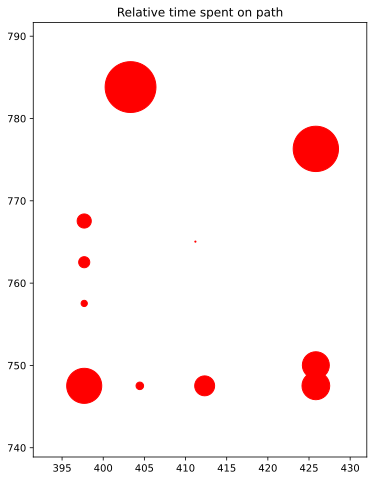

In [14]:
def time_spent_on_path(room, path, times, scale=200):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    minx, miny, maxx, maxy = room.room.bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    for path_idx, grid_idx in enumerate(greedy_path.points):
        x, y = room.guard_grid[grid_idx]
        ax.scatter([x], [y], color='red', s=[scale * times[path_idx]])
    ax.set_title('Relative time spent on path')
time_spent_on_path(room, greedy_path, greedy_times[-1])
plt.show()